# Modeling: Time Series & Classification — Live Lecture Notebook
*Session: Aug 22 (Fri)*

This notebook generates its **own synthetic data** (no external files) and demonstrates:
- Lag & rolling features for time series
- Time-aware train/test split vs random split
- A baseline return-forecast model
- A binary classifier for next-day direction
- Proper evaluation (RMSE / precision, recall, F1) and pitfalls

In [1]:
# 0) Setup
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit

np.random.seed(42)
sns.set()
plt.rcParams['figure.figsize'] = (9, 4)

## 1) Generate Synthetic Financial Series
We simulate a **regime-switching geometric random walk** with occasional jumps to create heavy tails.

In [2]:
n = 600  # ~2.5 years of business days
dates = pd.bdate_range('2020-01-01', periods=n)

# Regime means/vols
mu = np.where(np.arange(n) < n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n) < n//2, 0.01, 0.015)

eps = np.random.normal(mu, sigma)
# Add jumps
jumps = np.zeros(n)
jump_days = np.random.choice(np.arange(20, n-20), size=6, replace=False)
jumps[jump_days] = np.random.normal(0, 0.06, size=len(jump_days))
rets = eps + jumps

price = 100 * np.exp(np.cumsum(rets))
df = pd.DataFrame({'price': price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2020-01-01,100.528104,0.000000,0.000000
2020-01-02,100.419327,-0.001082,-0.001083
2020-01-03,101.102168,0.006800,0.006777
2020-01-06,102.684571,0.015652,0.015530
2020-01-07,102.475150,-0.002039,-0.002042


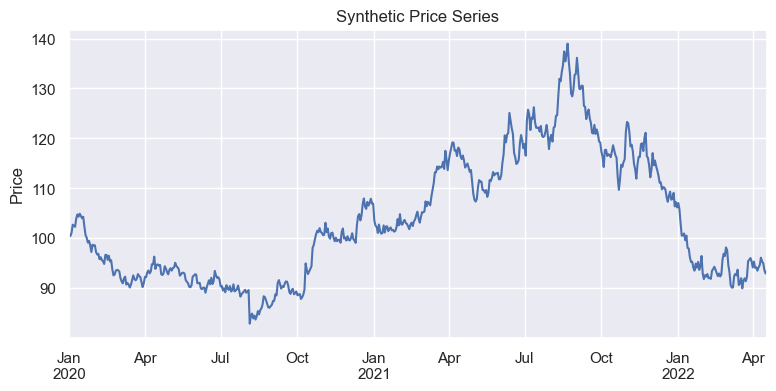

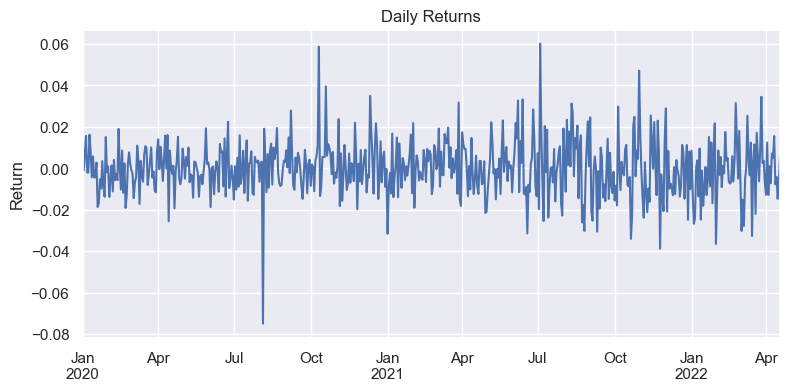

In [3]:
fig, ax = plt.subplots()
df['price'].plot(ax=ax)
ax.set_title('Synthetic Price Series'); ax.set_ylabel('Price'); plt.show()
fig, ax = plt.subplots()
df['ret'].plot(ax=ax)
ax.set_title('Daily Returns'); ax.set_ylabel('Return'); plt.show()

## 2) Create Time-Series Features
- `lag_1`, `lag_5` of returns
- `roll_mean_5`
- `roll_vol_20` (rolling std)

In [4]:
df['lag_1'] = df['ret'].shift(1)
df['lag_5'] = df['ret'].shift(5)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
df['roll_vol_20'] = df['ret'].rolling(20).std().shift(1)

# Targets
df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret'] > 0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,price,ret,log_ret,lag_1,lag_5,roll_mean_5,roll_vol_20,y_next_ret,y_up
2020-01-29,98.678487,0.015069,0.014956,-0.013728,-0.005309,-0.006822,0.009467,-0.001956,0
2020-01-30,98.485487,-0.001956,-0.001958,0.015069,-0.009780,-0.002747,0.010177,0.000976,1
2020-01-31,98.581585,0.000976,0.000975,-0.001956,0.003448,-0.001182,0.010180,-0.013851,0
2020-02-03,97.216164,-0.013851,-0.013947,0.000976,-0.008742,-0.001676,0.010030,-0.005131,0
2020-02-04,96.717385,-0.005131,-0.005144,-0.013851,-0.013728,-0.002698,0.009578,0.001410,1


## 3) Time-Aware Split
Train = first 80%, Test = final 20%.

In [5]:
cut = int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features = ['lag_1','lag_5','roll_mean_5','roll_vol_20']
X_train, y_train = train[features], train['y_next_ret']
X_test,  y_test  = test[features],  test['y_next_ret']
X_train.shape, X_test.shape

((463, 4), (116, 4))

## 4) Forecasting Baseline (Regression on Returns)

In [12]:
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_train, y_train)
pred_ts = reg.predict(X_test)
mae = mean_absolute_error(y_test, pred_ts)
rmse = mean_squared_error(y_test, pred_ts) ** 0.5  # Compute RMSE manually

r2 = r2_score(y_test, pred_ts)
mae, rmse, r2

(0.011647715682016125, 0.014553899625248182, -0.02725906802410205)

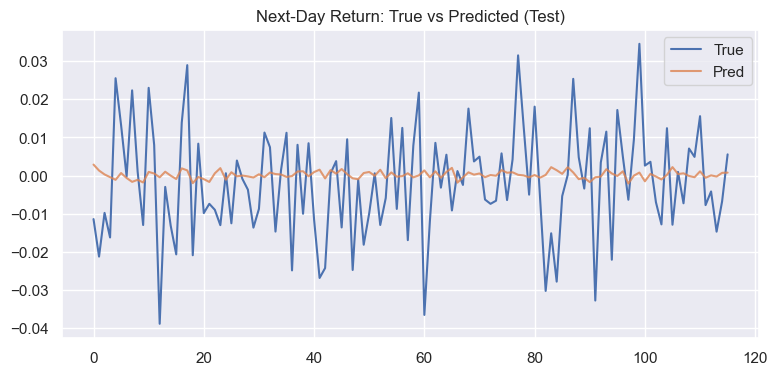

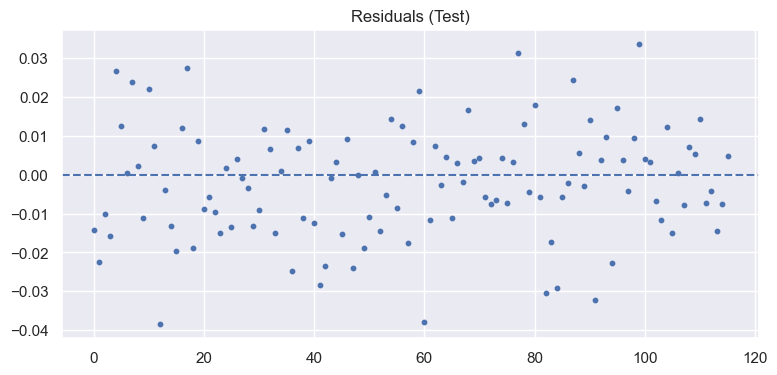

In [13]:
fig, ax = plt.subplots()
y_test.reset_index(drop=True).plot(ax=ax, label='True')
pd.Series(pred_ts).plot(ax=ax, label='Pred', alpha=0.8)
ax.set_title('Next-Day Return: True vs Predicted (Test)')
ax.legend(); plt.show()

resid = y_test.values - pred_ts
fig, ax = plt.subplots()
ax.scatter(range(len(resid)), resid, s=10)
ax.axhline(0, ls='--')
ax.set_title('Residuals (Test)'); plt.show()

### TimeSeriesSplit Illustration (no deep CV today)

In [8]:
tscv = TimeSeriesSplit(n_splits=3)
for i, (tr, va) in enumerate(tscv.split(df_feat)):
    print(f"Fold {i+1}: train={tr[:2]}..{tr[-1]}, val={va[:2]}..{va[-1]}")

Fold 1: train=[0 1]..146, val=[147 148]..290
Fold 2: train=[0 1]..290, val=[291 292]..434
Fold 3: train=[0 1]..434, val=[435 436]..578


## 5) Classification Target: Next-Day Up/Down

In [9]:
Xc_train, yc_train = train[features], train['y_up']
Xc_test,  yc_test  = test[features],  test['y_up']
logit_pipe = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000))])
tree_pipe = Pipeline([('clf', DecisionTreeClassifier(max_depth=4, random_state=42))])
logit_pipe.fit(Xc_train, yc_train)
tree_pipe.fit(Xc_train, yc_train)
pred_log = logit_pipe.predict(Xc_test)
pred_tree = tree_pipe.predict(Xc_test)
print('Logistic Report:\n', classification_report(yc_test, pred_log))
print('Tree Report:\n', classification_report(yc_test, pred_tree))

Logistic Report:
               precision    recall  f1-score   support

           0       0.55      0.48      0.51        62
           1       0.48      0.54      0.50        54

    accuracy                           0.51       116
   macro avg       0.51      0.51      0.51       116
weighted avg       0.51      0.51      0.51       116

Tree Report:
               precision    recall  f1-score   support

           0       0.61      0.50      0.55        62
           1       0.52      0.63      0.57        54

    accuracy                           0.56       116
   macro avg       0.57      0.56      0.56       116
weighted avg       0.57      0.56      0.56       116



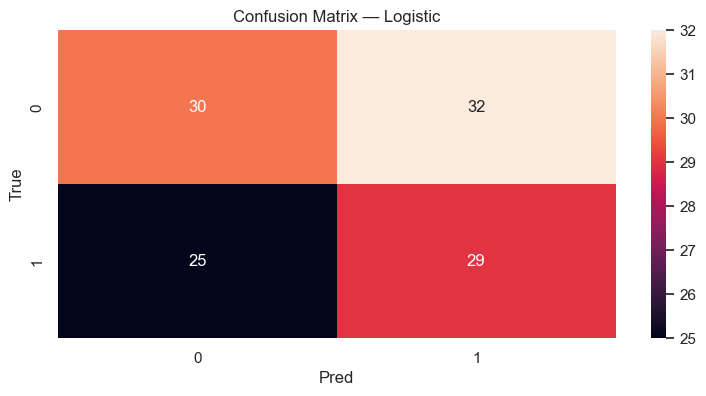

In [10]:
cm = confusion_matrix(yc_test, pred_log)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix — Logistic'); plt.xlabel('Pred'); plt.ylabel('True'); plt.show()

### Shuffle vs Time-Aware Split (Cautionary Demo)
We show how shuffling can inflate scores by leaking future distributional info.

In [11]:
# BAD: Random split on time series (for demo purposes only)
Xc = df_feat[features]
yc = df_feat['y_up']
X_tr_bad, X_te_bad, y_tr_bad, y_te_bad = train_test_split(Xc, yc, test_size=0.2, shuffle=True, random_state=42)
logit_bad = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
logit_bad.fit(X_tr_bad, y_tr_bad)
pred_bad = logit_bad.predict(X_te_bad)
print('Random split (BAD) report:\n', classification_report(y_te_bad, pred_bad))

Random split (BAD) report:
               precision    recall  f1-score   support

           0       0.53      0.44      0.48        59
           1       0.51      0.60      0.55        57

    accuracy                           0.52       116
   macro avg       0.52      0.52      0.51       116
weighted avg       0.52      0.52      0.51       116



## 6) Takeaways
- Use returns, not raw prices, to reduce spurious results.
- Avoid leakage with careful shifting and time-aware splits.
- Choose metrics aligned with costs (precision/recall).
- Pipelines improve reproducibility.